<a href="https://colab.research.google.com/github/petewarden/pico_colabs/blob/main/Building_Person_Detection_for_the_Arducam_Pico4ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building Blink for the Raspberry Pi Pico

*By [Pete Warden](https://twitter.com/petewarden), peteward@stanford.edu*

This notebook demonstrates how to compile and deploy a simple program to blink an LED on a Raspberry Pi Pico microcontroller. It is based on the official [Getting Started Guide](https://datasheets.raspberrypi.com/pico/getting-started-with-pico.pdf), but because it can be [run in a web browser Google's Colab](https://colab.research.google.com/github/petewarden/pico_colabs/blob/main/Building_Blink_for_the_Raspberry_Pi_Pico.ipynb), you don't have to install any software on your local machine to use it. I find this makes it useful for teaching, since students can use their own laptops and I don't have to debug the problems that come up when trying to install development tools across a lot of different operating systems like Windows, MacOS, and ChromeOS. 

If you follow the instructions and select each code snippet in turn and press shift-return or the play button at the top left, you should have a binary you can load onto your board in less than a minute. If you want to do a speed run to the end, you can also choose `Runtime->Run all` from the menu.

## Install the SDK and Examples

The code below follows the steps in Chapter 2 of the Getting Started Guide. It creates a top-level directory called `pico`, and then pulls the [SDK](https://github.com/raspberrypi/pico-sdk.git) and [examples](https://github.com/raspberrypi/pico-examples.git) from GitHub. 

You can view the files in the browser by selecting the folder icon on the left of the window.

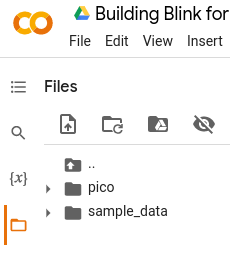

In [ ]:
!mkdir pico
%cd pico
!git clone -b master https://github.com/raspberrypi/pico-sdk.git
%cd pico-sdk
!git submodule update --init
%cd ..
!git clone -b master https://github.com/raspberrypi/pico-examples.git

## Install the Toolchain

Because we're running this notebook on an x86 server in the cloud, but we want to compile for the RP2040 microcontroller, we need to fetch a special cross-compiler that runs on the notebook platform but targets the right MCU. This is fully described in section 2.2 of the Getting Started Guide, but we do this by installing the right packages through Ubuntu's package manager.

In [ ]:
!sudo apt update
!sudo apt install cmake gcc-arm-none-eabi libnewlib-arm-none-eabi build-essential libstdc++-arm-none-eabi-newlib

## Setting up the Build System

By default the Pico uses Cmake to handle compiling programs. These code snippets tell the build system where the SDK files are (using the `PICO_SDK_PATH` environment variable) and create the files that will later be used to do the compilation. Cmake uses a two-step process, first setting up the needed files, which will then be used to do the actual building. It can be a bit confusing, but we're just doing the first step (setting up the files) by running the `cmake` command, the actual compilation happens in the next section. These steps are taken from Chapter 3 of the guide.

In [ ]:
%cd pico-examples
!mkdir build
%cd build
%env PICO_SDK_PATH=../../pico-sdk
!cmake ..

## Compiling the Blink Example

Now we have set up the build files, we can navigate to the `blink` folder in the examples and compile the C files into an executable. The `-j` argument tells the `make` command to build as much in parallel as possible for speed.

You shouldn't hit any compilation errors with this prebuilt code, but if you have a modified program and run into problems, removing that `-j` can make it easier to see which file is the cause, since only one will be compiled at once.

In [ ]:
%cd blink
!make -j

## Load and Run the Executable

To test the program you'll need a Pico and a USB cable to connect to your machine. As described in Chapter 3.2 of the Guide, if you find the `bootsel` button on your Pico, hold it down, and then plug the USB cable into your laptop, you should see a new drive appear in your machine's file system, as if you'd plugged in a USB memory stick. The drive should be called something like `RPI-RPI2`. This is how you can transfer the executable you've built onto the Pico.

In the file system view of the browser (visible by clicking on the folder on the left hand side of this web page) open up the `pico` folder, then go to `pico-examples`, then `build`, and then `blink`. You should see a list of files, including `blink.uf2`. This is the executable we want to copy to the microcontroller. Right click on it and choose `Download` from the menu. This will transfer the executable into the Downloads folder of your local machine.

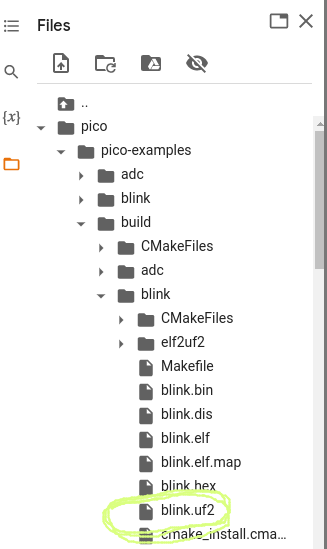

Once you've located that file in your local file system, drag it onto the Pico drive. If everything worked successfully you should see the drive disappear, the board reboot, and an LED blink about once a second. Congratulations, you've just built your first Raspberry Pi Pico program!

## Going Further

Now you've built blink, you can try exploring some of the other examples, by changing the directory with something like `%cd /pico/pico-examples/build/hello_world`, and then building with `!make -j`. Most of the other examples use `printf()` to write out text through a USB serial device though, so you'll need to look at Chapter 4 of the Guide to understand how to access that with an application like `minicom`.